# Posterior and Marginal distributions

This notebook is the continuation of `bandwidths.ipynb` notebook, apliying the bw results and the class for get the n-dimentional PDF. 

#### Some considerations: 
1. As **prior** information we will take the cleaned (without NaN or inf values) information from exoplanet.eu, this is the first part of notebook.

2. The PDF from `oiptimal_pdf` class  fulfills the functions of **likelihood** for a certain number of variables in synthetic systems with no-pertutbation, low perturbation and high perturbation. 

3. To get the **marginal** distributions of a variable of interest, we go in the same way that the example marginalization in the notebook `3D.ipynb`.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data Cleaning

### 1.1 Simulation data   

see the notation according to <a href="https://github.com/saint-germain/population_synthesis/blob/master/README.md ">Readme.md</a> from `Population_synthesis` project.





In [3]:
#========================== Simulation Data ==========================
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None); dn["gia"]=dn.ngi>0 #without pertubtations 
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None); dl["gia"]=dl.ngi>0 #with low pertubtations 
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None); dh["gia"]=dh.ngi>0 #with high pertubtations

In [4]:
#======================= Simulation variables ========================
##Terrestrial: t; giant;g
dnt=dn[~dn["gia"]]; dng=dn[dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]]; dlg=dl[dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]]; dhg=dh[dh["gia"]] # high pertubtations 

x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [5]:
dnt.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
1,1,5.0,2.932894,12.0,17.882769,0.000488,102.431593,0.110,38.977428,1.075269,-0.150160,1.014449e+06,5.464831,0.0,17.882769,0.0,False,-3.311837,0.467296
3,3,8.0,5.740174,9.0,8.166382,0.000163,62.737337,0.150,58.158928,1.076658,-0.282408,6.017040e+06,4.704798,0.0,8.166382,0.0,False,-3.786940,0.758925
5,5,15.0,8.394027,8.0,16.003091,0.000436,106.824759,0.110,38.167542,0.986003,0.388613,2.435406e+06,5.218175,0.0,16.003091,0.0,False,-3.360068,0.923970
6,6,16.0,4.289089,24.0,12.426573,0.000219,118.543720,0.170,45.042137,1.258747,-0.352459,1.107032e+06,4.469478,0.0,12.426573,0.0,False,-3.658976,0.632365
7,7,17.0,3.771156,12.0,16.762554,0.000811,35.587738,0.062,49.645451,0.739731,0.121866,9.050091e+06,7.257983,0.0,16.762554,0.0,False,-3.090930,0.576474


### 1.2 Observational data 

Data get from <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [6]:
data_o = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                       usecols = ['mass','mass_error_min','semi_major_axis','semi_major_axis_error_min','star_name',
                                  'star_metallicity','star_metallicity_error_min','star_mass','star_mass_error_min'])

data_o = data_o.replace([np.inf, -np.inf], np.nan) 
data_o = data_o.replace([0], np.nan)
data_o = data_o.dropna()

In [7]:
data_o = data_o[['star_name','mass','mass_error_min', 'semi_major_axis', 'semi_major_axis_error_min', 
                 'star_metallicity', 'star_metallicity_error_min', 'star_mass', 'star_mass_error_min']]

data_o = data_o.assign(CM_i = data_o["semi_major_axis"]*data_o["mass"])
data_o = data_o.assign(dCM_i= data_o["CM_i"]*(data_o["mass_error_min"].divide(data_o["mass"])+data_o["semi_major_axis_error_min"].divide(data_o["semi_major_axis"])))

In [8]:
number=(data_o["star_name"].value_counts()).to_frame()

In [9]:
def NewData(data):
   
    p_system = data.groupby("star_name")
    
    Mtp   = p_system['mass'].sum();             dMtp   = p_system['mass_error_min'].sum();  
    ms    = p_system['star_mass'].mean();        dms    = p_system['star_mass_error_min'].mean()
    metal = p_system['star_metallicity'].mean(); dmetal = p_system['star_metallicity_error_min'].mean()
    
    
    CoM  = p_system['CM_i'].sum().divide(p_system["mass"].sum())
    dCoM = CoM*((p_system['dCM_i'].sum()/p_system['CM_i'].sum()) + (p_system['mass_error_min'].sum())/p_system['mass'].sum())
    
    NewData = pd.DataFrame({'sys_name':list(p_system.groups.keys()),
                            'Mtp':Mtp, 'dMtp':dMtp,
                            'com':CoM.tolist(), 'dcom':dCoM.tolist(), 
                            'ms':ms, 'dms':dms, 'metal':metal, 'dmetal':dmetal})
    return NewData

In [10]:
obs_data = NewData(data_o)
obs_data = obs_data.assign(n_planets = number)
obs_data = obs_data.sort_values(by=['n_planets'], ascending=False)
obs_data.head()

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
TRAPPIST-1,TRAPPIST-1,0.017701,0.010374,0.029040,0.034407,0.080,0.007,0.04,0.08,7
K2-138,K2-138,0.113900,0.030500,0.083596,0.053756,0.930,0.060,0.16,0.04,6
GJ 876,GJ 876,2.861000,0.045000,0.185302,0.005413,0.334,0.030,0.05,0.20,4
WASP-47,WASP-47,2.511800,0.097400,0.760462,0.220362,1.110,0.490,0.18,0.07,4
Kepler-289,Kepler-289,0.451000,0.077000,0.489512,0.184174,1.080,0.020,0.05,0.04,3


In [11]:
#system_i = data_o[data_o.star_name == "Kepler-289"]  
#system_i

## 2. Posterior probability 

### 2.1 Likelihood

In [245]:
import nbimporter
from bandwidths import optimal_pdf #import the class for get the pdf.

In this example we take the variables `dng.ms`, `dng.metal` and `dng.nplanets` 

In [246]:
likel = optimal_pdf(dng.ms, dng.metal, dng.nplanets)
likel.pdf()

In [247]:
likelihood = likel.pdf_std #in standard space
#likelihood

### 2.2 Prior infromation

At first example we take the system "Kepler-289" to get the prior information of stellar mass `ms` and its metallicity `metal`, reported in the catalog of <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [248]:
from scipy.stats import truncnorm
systm = obs_data[obs_data.sys_name == "Kepler-289"] 
systm

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
Kepler-289,Kepler-289,0.451,0.077,0.489512,0.184174,1.08,0.02,0.05,0.04,3


In [306]:
# per data needs a list with [mu, sigma]: 

class prior(optimal_pdf):
    
    def __init__(self, *args):
        
        lenght = 1000
        self.org_data = np.array(args)
        
        d = [np.linspace(args[i][0]-3*args[i][1], args[i][0]+3*args[i][1],lenght) for i in range(len(args))]
        
        self.prior_data = [np.ravel(d[i]) for i in range(len(d))]
        
        optimal_pdf.__init__(self,*self.prior_data)
        optimal_pdf.grids(self)
        
    def prior_pdfs(self):
        
        self.prior_pdfs = [] 
        minimum = 0
        
        for i in range(len(self.org_data)): 
            
            a = (minimum - self.org_data[i][0]) / self.org_data[i][1] 
            b = (3*self.org_data[i][1]) / self.org_data[i][1] 
            
            pdf = truncnorm.pdf(self.prior_data[i], a, b,
                                scale=self.org_data[i][1], 
                                loc=self.org_data[i][0])
            
            self.prior_pdfs.append(pdf)
                
        #return self.pdf_prior

In [299]:
A = prior([systm.ms, systm.dms],[systm.metal,systm.dmetal])
A.prior_pdfs()

In [310]:
len(A.data_std[0])

2

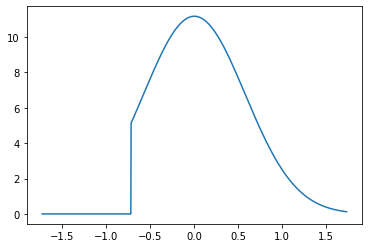

In [311]:
plt.plot(A.data_std[:,1], A.prior_pdfs[1])

In [182]:
from scipy.stats import truncnorm

In [301]:
mu_x, sigma_x = systm.metal, systm.dmetal

x = np.linspace(mu_x-3*sigma_x, mu_x+3*sigma_x,100).ravel()

a = (0-mu_x.values) / sigma_x.values 
b = (mu_x.values + 3*sigma_x.values - mu_x.values) / sigma_x.values

prior_x = stats.norm.pdf(x, loc = mu_x, scale = sigma_x)  

In [302]:
r = truncnorm.rvs(a, b, scale=sigma_x, loc=mu_x, size=1000)
print(r.mean(),r.std())
print(x.mean(),x.std())

0.05901637613891446 0.03353328240382672
0.050000000000000024 0.0699783516308415


In [303]:
pdf = truncnorm.pdf(x, a, b, scale=sigma_x, loc=mu_x)

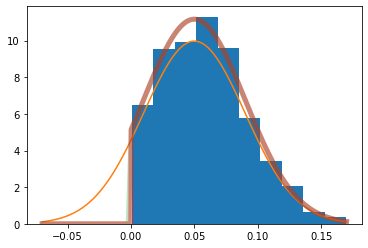

In [305]:
plt.hist(r, density = True)
plt.plot(x,prior_x)
plt.plot(x,pdf, lw=5, alpha=.3)
plt.plot(A.prior_data[1], A.prior_pdfs[1], lw=5, alpha=.5)

In [54]:
AAA = np.array([[systm.ms, systm.dms],[systm.metal,systm.dmetal]])

In [74]:
AAA[:,0]

array([[0.93],
       [0.16]])

In [21]:
data = np.array([systm.ms, systm.dms,systm.metal,systm.dmetal]).reshape(2,2)

In [22]:
data[0]

array([0.93, 0.06])

In [23]:
x = np.linspace(data[0][0]-3*data[0][1], data[0][0]+3*data[0][1],100)

In [24]:
x

array([0.75      , 0.75363636, 0.75727273, 0.76090909, 0.76454545,
       0.76818182, 0.77181818, 0.77545455, 0.77909091, 0.78272727,
       0.78636364, 0.79      , 0.79363636, 0.79727273, 0.80090909,
       0.80454545, 0.80818182, 0.81181818, 0.81545455, 0.81909091,
       0.82272727, 0.82636364, 0.83      , 0.83363636, 0.83727273,
       0.84090909, 0.84454545, 0.84818182, 0.85181818, 0.85545455,
       0.85909091, 0.86272727, 0.86636364, 0.87      , 0.87363636,
       0.87727273, 0.88090909, 0.88454545, 0.88818182, 0.89181818,
       0.89545455, 0.89909091, 0.90272727, 0.90636364, 0.91      ,
       0.91363636, 0.91727273, 0.92090909, 0.92454545, 0.92818182,
       0.93181818, 0.93545455, 0.93909091, 0.94272727, 0.94636364,
       0.95      , 0.95363636, 0.95727273, 0.96090909, 0.96454545,
       0.96818182, 0.97181818, 0.97545455, 0.97909091, 0.98272727,
       0.98636364, 0.99      , 0.99363636, 0.99727273, 1.00090909,
       1.00454545, 1.00818182, 1.01181818, 1.01545455, 1.01909

In [35]:
#AA = prior(x.ravel(),y.ravel())
#AA.grids()

In [ ]:
AA.std_grid[0]

In [ ]:
eye = np.ones([100,100])

In [ ]:
prior = eye*prior_x*prior_y.T

In [ ]:
plt.contour(AA.std_grid[0],AA.std_grid[1],prior)

In [ ]:
x = np.linspace(systm.ms-3*systm.dms,systm.ms+3*systm.dms,100)
y = np.linspace(systm.metal-systm.dmetal,systm.metal+systm.dmetal,100)

X,Y = np.meshgrid(x,y)

prior = bi_norm(X,Y,systm.Mtp.values, systm.dMtp.values, systm.metal.values, systm.dmetal.values)

In [ ]:
prior

In [ ]:
prior_std = ((prior - np.mean(prior, axis=0))/np.std(prior, axis = 0)).reshape(X.shape)
#prior_std

In [ ]:
plt.contour(prior_std)
#prior

In [ ]:
x_y = stats.norm.pdf(x)
y_y = stats.norm.pdf(y)

In [ ]:
plt.plot(x,x_y)

In [ ]:
prior_2=((np.ones([100,100]).T*prior_y).T)*prior_x
plt.contour(prior_2)

### 2.2 Likelihood